This file replicates Figures 1 through 4. We credit Jaroslav Borovička for the baseline code.

Import relevant packages.

In [1]:
# import packages
import numpy as np

# load econutil package with some frequently used functions
import econutil as ec

Root package econutil imported.


Function that solves for asset pricing moments in the Mehra-Prescott economy.

In [2]:
def solve_Mehra_Prescott(model):
    
    S = model["SDF"]
    P = model["P"]
    GAMMAG = model["GAMMAG"]
    
    N = P.shape[0]
    I = np.identity(N)
    one = np.ones([N,1])
    
    # first compute the unconditional stationary distribution PII (assuming it is unique)
    # unconditional stationary distribution is the eigenvector of P' associated
    # with eigenvalue equal to 1 (the largest eigenvalue)
    eigval,eigvec = np.linalg.eig(P.transpose())
    idx = np.abs(eigval).argsort()
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]
    PII = eigvec[:,-1:] /sum( eigvec[:,-1])

    # conditional gross risk-free rate (Nx1 vector)
    # Rf = 1 / (np.multiply(P,S)*one)
    Rf = 1 / ((P * S) @ one)
    # unconditional gross risk-free rate, stored as a scalar
    ERf = (Rf.transpose() @ PII).item()
    
    # recursive formula for the price-dividend ratio: q =  P*S*GAMMAG @ (q + 1)
    # where * is elementwise multiplication, @ is matrix multiplication, 1 is an Nx1 vector of ones
    # solution given by
    # q = inv(I - P*S*GAMMAG) * (P*S*GAMMAG)*1

    # solution for the infinite-horizon asset only valid
    # if P*S*G has eigenvalues inside the unit circle
    M = P*S*GAMMAG
    eigval,eigvec = np.linalg.eig(M)
    maxeig = max(eigval)

    if (maxeig < 1):
        # asset price (Nx1 vector)
        q = np.linalg.inv(I - M) @ (M @ one)
        # returns (NxN matrix of returns R(i,j)
        R = ((1/q) @ (q.transpose()+1)) * GAMMAG
        # conditional expected returns (Nx1 vector)
        EtR = (R * P) @ one
        # unconditional expected return
        ER = (EtR.transpose() @ PII).item()
        # excess returns, realized and expected
        Re = R - np.tile(Rf,[1,N])
        EtRe = EtR - Rf
        ERe = ER - ERf
    else:
        q = (np.empty([N,1]))*np.nan
        R = (np.empty([N,N]))*np.nan
        EtR = (np.empty([N,1]))*np.nan
        ER = np.nan
        Re = (np.empty([N,N]))*np.nan
        EtRe = (np.empty([N,1]))*np.nan
        ERe = np.nan

    sol = {"PII": PII, "Rf": Rf, "ERf": ERf, "q": q, "R": R, "EtR": EtR, "ER": ER, "Re": Re, "EtRe": EtRe, "ERe": ERe}
    return sol

# Original Mehra-Prescott Model

In [3]:
# model specification
model = {"PHI": 0.43, "MU": 0.018, "DELTA": 0.036}

model["P"] = np.array([[model["PHI"], 1-model["PHI"]], [1-model["PHI"], model["PHI"]]])
model["GAMMAC"] = np.array([[1+model["MU"]+model["DELTA"],1+model["MU"]-model["DELTA"]], [1+model["MU"]+model["DELTA"],1+model["MU"]-model["DELTA"]]])
model["GAMMAG"] = model["GAMMAC"].copy()

beta_vec = np.linspace(0.001,1,200)
gamma_vec = np.linspace(0,10,400)

ERe_mat_original = np.zeros([len(beta_vec),len(gamma_vec)])
ERf_mat_original = np.zeros([len(beta_vec),len(gamma_vec)])

for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        model["BETA"] = bet
        model["GAMMA"] = gam
        model["SDF"] = model["BETA"] * np.power(model["GAMMAC"],-model["GAMMA"])
        sol = solve_Mehra_Prescott(model)
        ERe_mat_original[i,j] = sol["ERe"]
        ERf_mat_original[i,j] = sol["ERf"]

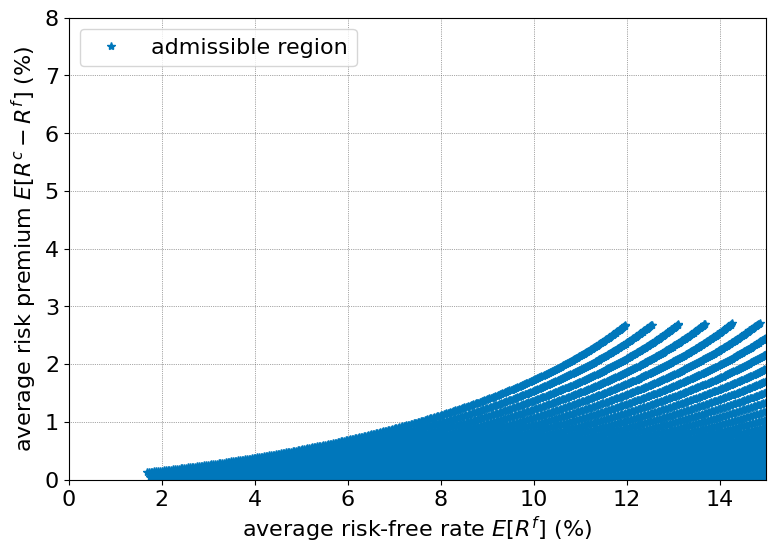

In [4]:
param = {'figsize' : [9,6], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [0,15], 'ylim': [0,8],
         'xlabel': r'average risk-free rate $E[R^f]\ (\%)$', 'ylabel': r'average risk premium $E[R^c - R^f]\ (\%)$',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

fig,ax = ec.GenerateTSPlot(param)

ax.plot((ERf_mat_original.flatten()-1)*100, ERe_mat_original.flatten()*100,linewidth=0,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='admissible region');

x = ax.legend(loc="upper left")

fig.set_facecolor('#FFFFFF')

# Our Model

In [5]:
# model specification
model = {"PHI": 0.43, "MU": 0.018, "DELTA": 0.036, "d1": 0.024, "d2": 0.024, "p": 0, "psi": 0.85}

model["P"] = np.array([[model["PHI"], 1 - model["PHI"] - model["d1"], model["d1"]], 
                       [1 - model["PHI"] - model["d2"], model["PHI"], model["d2"]],
                       [0.5 - 0.5 * model["p"], 0.5 - 0.5 * model["p"], model["p"]]])

model["GAMMAC"] = np.array([[1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])], 
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])],
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])]])

model["GAMMAG"] = model["GAMMAC"].copy()

beta_vec = np.linspace(0.001,1,200)
gamma_vec = np.linspace(0,10,400)

# beta_vec = np.linspace(0.000001, 1, 11)
# gamma_vec = np.linspace(0, 10, 11)

ERe_mat = np.zeros([len(beta_vec),len(gamma_vec)])
ERf_mat = np.zeros([len(beta_vec),len(gamma_vec)])

for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        model["BETA"] = bet
        model["GAMMA"] = gam
        model["SDF"] = model["BETA"] * np.power(model["GAMMAC"],-model["GAMMA"])
        sol = solve_Mehra_Prescott(model)
        ERe_mat[i,j] = sol["ERe"]
        ERf_mat[i,j] = sol["ERf"]

In [6]:
sol["PII"]

array([[0.48828125],
       [0.48828125],
       [0.0234375 ]])

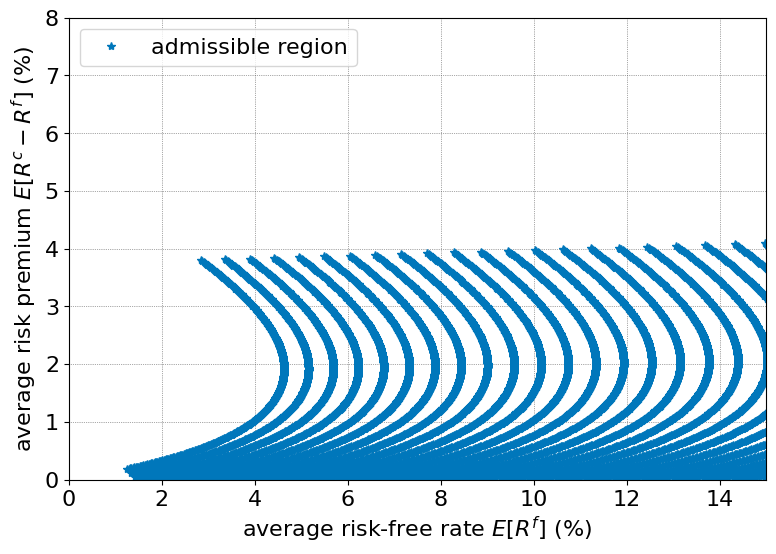

In [7]:
param = {'figsize' : [9,6], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [0,15], 'ylim': [0,8],
         'xlabel': r'average risk-free rate $E[R^f]\ (\%)$', 'ylabel': r'average risk premium $E[R^c - R^f]\ (\%)$',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

fig,ax = ec.GenerateTSPlot(param)

ax.plot((ERf_mat.flatten()-1)*100, ERe_mat.flatten()*100,linewidth=0,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='admissible region');

x = ax.legend(loc="upper left")

fig.set_facecolor('#FFFFFF')

## Without vs. With Disaster State Analysis

In [8]:
import matplotlib.pyplot as plt

# data = []
# for i,bet in enumerate(beta_vec):
#     for j,gam in enumerate(gamma_vec):
#         data.append(ERf_mat_original[i,j] - ERf_mat[i,j]) # Average risk-free rate tends to be bigger for original model

# plt.hist(data, bins=30, edgecolor='black')
# plt.show()

In [9]:
counter = 0
for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        if ERf_mat[i,j] > ERf_mat_original[i,j]:
            print(f"Disaster model yields higher average risk-free rate when beta: {beta_vec[i]}, gamma: {gamma_vec[j]}")
            counter += 1

Disaster model yields higher average risk-free rate when beta: 0.10642211055276384, gamma: 0.0
Disaster model yields higher average risk-free rate when beta: 0.11646231155778895, gamma: 0.0
Disaster model yields higher average risk-free rate when beta: 0.13152261306532664, gamma: 0.0
Disaster model yields higher average risk-free rate when beta: 0.14658291457286435, gamma: 0.0
Disaster model yields higher average risk-free rate when beta: 0.15662311557788947, gamma: 0.0
Disaster model yields higher average risk-free rate when beta: 0.16164321608040202, gamma: 0.0
Disaster model yields higher average risk-free rate when beta: 0.1767035175879397, gamma: 0.0
Disaster model yields higher average risk-free rate when beta: 0.2218844221105528, gamma: 0.0
Disaster model yields higher average risk-free rate when beta: 0.22690452261306535, gamma: 0.0
Disaster model yields higher average risk-free rate when beta: 0.23694472361809046, gamma: 0.0
Disaster model yields higher average risk-free rate 

In [10]:
counter / (200 * 400)

0.000525

In [11]:
# data = []
# for i,bet in enumerate(beta_vec):
#     for j,gam in enumerate(gamma_vec):
#         data.append(ERe_mat[i,j] - ERe_mat_original[i,j]) # Average risk premium tends to be bigger for disaster model

# plt.hist(data, bins=30, edgecolor='black')
# plt.show()

In [12]:
counter = 0
for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        if ERe_mat[i,j] < ERe_mat_original[i,j]:
            print(f"Original model yields higher average risk premium when beta: {beta_vec[i]}, gamma: {gamma_vec[j]}")
            counter += 1

Original model yields higher average risk premium when beta: 0.006020100502512563, gamma: 0.0
Original model yields higher average risk premium when beta: 0.011040201005025126, gamma: 0.0
Original model yields higher average risk premium when beta: 0.021080402010050254, gamma: 0.0
Original model yields higher average risk premium when beta: 0.04116080402010051, gamma: 0.0
Original model yields higher average risk premium when beta: 0.08634170854271357, gamma: 0.0
Original model yields higher average risk premium when beta: 0.09136180904522614, gamma: 0.0
Original model yields higher average risk premium when beta: 0.0963819095477387, gamma: 0.0
Original model yields higher average risk premium when beta: 0.13152261306532664, gamma: 0.0
Original model yields higher average risk premium when beta: 0.14156281407035176, gamma: 0.0
Original model yields higher average risk premium when beta: 0.14658291457286435, gamma: 0.0
Original model yields higher average risk premium when beta: 0.16164

In [13]:
counter / (200 * 400)

0.0007375

# Lower $d_1, d_2$

In [14]:
# model specification
model = {"PHI": 0.43, "MU": 0.018, "DELTA": 0.036, "d1": 0.010, "d2": 0.010, "p": 0, "psi": 0.85}

model["P"] = np.array([[model["PHI"], 1 - model["PHI"] - model["d1"], model["d1"]], 
                       [1 - model["PHI"] - model["d2"], model["PHI"], model["d2"]],
                       [0.5 - 0.5 * model["p"], 0.5 - 0.5 * model["p"], model["p"]]])

model["GAMMAC"] = np.array([[1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])], 
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])],
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])]])

model["GAMMAG"] = model["GAMMAC"].copy()

beta_vec = np.linspace(0.001,1,200)
gamma_vec = np.linspace(0,10,400)

# beta_vec = np.linspace(0.000001, 1, 11)
# gamma_vec = np.linspace(0, 10, 11)

ERe_mat_lower_d = np.zeros([len(beta_vec),len(gamma_vec)])
ERf_mat_lower_d = np.zeros([len(beta_vec),len(gamma_vec)])

for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        model["BETA"] = bet
        model["GAMMA"] = gam
        model["SDF"] = model["BETA"] * np.power(model["GAMMAC"],-model["GAMMA"])
        sol = solve_Mehra_Prescott(model)
        ERe_mat_lower_d[i,j] = sol["ERe"]
        ERf_mat_lower_d[i,j] = sol["ERf"]

In [15]:
sol["PII"]

array([[0.4950495 ],
       [0.4950495 ],
       [0.00990099]])

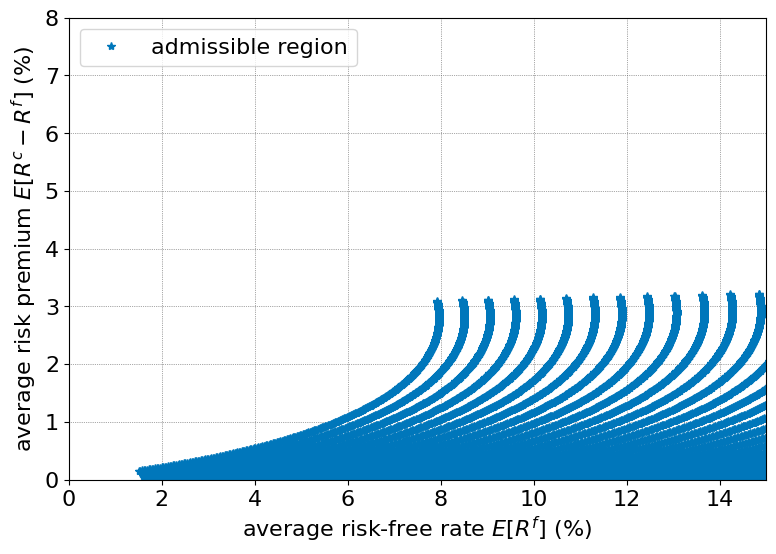

In [16]:
param = {'figsize' : [9,6], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [0,15], 'ylim': [0,8],
         'xlabel': r'average risk-free rate $E[R^f]\ (\%)$', 'ylabel': r'average risk premium $E[R^c - R^f]\ (\%)$',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

fig,ax = ec.GenerateTSPlot(param)

ax.plot((ERf_mat_lower_d.flatten()-1)*100, ERe_mat_lower_d.flatten()*100,linewidth=0,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='admissible region');

x = ax.legend(loc="upper left")

fig.set_facecolor('#FFFFFF')

## Analysis

In [17]:
# data = []
# for i,bet in enumerate(beta_vec):
#     for j,gam in enumerate(gamma_vec):
#         data.append(ERf_mat_lower_d[i,j] - ERf_mat[i,j]) # Average risk-free rate tends to be bigger for lower d

# plt.hist(data, bins=30, edgecolor='black')
# plt.show()

In [18]:
counter = 0
for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        if ERf_mat[i,j] > ERf_mat_lower_d[i,j]:
            print(f"Lower d yields lower average risk-free rate when beta: {beta_vec[i]}, gamma: {gamma_vec[j]}")
            counter += 1

Lower d yields lower average risk-free rate when beta: 0.01606030150753769, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.026100502512562816, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.13152261306532664, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.1767035175879397, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.22690452261306535, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.2821256281407035, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.2871457286432161, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.2921658291457287, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.36746733668341713, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.37750753768844225, gamma: 0.0
Lower d yields lower average risk-free rate when beta: 0.48794974874371866, gamma: 0.0
Lower d yields lower average risk-free rate wh

In [19]:
counter / (200 * 400)

0.0003125

In [20]:
counter = 0
for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        if ERe_mat[i,j] < ERe_mat_lower_d[i,j]:
            print(f"Lower d yields higher average risk premium when beta: {beta_vec[i]}, gamma: {gamma_vec[j]}")
            counter += 1

Lower d yields higher average risk premium when beta: 0.011040201005025126, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.026100502512562816, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.07630150753768845, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.08634170854271357, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.09136180904522614, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.10140201005025126, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.1114422110552764, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.12650251256281408, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.13152261306532664, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.1365427135678392, gamma: 0.0
Lower d yields higher average risk premium when beta: 0.14156281407035176, gamma: 0.0
Lower d yields higher average risk premium when beta: 

In [21]:
counter / (200 * 400)

0.0007625

# Lower $\psi$

In [22]:
# model specification
model = {"PHI": 0.43, "MU": 0.018, "DELTA": 0.036, "d1": 0.024, "d2": 0.024, "p": 0, "psi": 0.80}

model["P"] = np.array([[model["PHI"], 1 - model["PHI"] - model["d1"], model["d1"]], 
                       [1 - model["PHI"] - model["d2"], model["PHI"], model["d2"]],
                       [0.5 - 0.5 * model["p"], 0.5 - 0.5 * model["p"], model["p"]]])

model["GAMMAC"] = np.array([[1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])], 
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])],
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])]])

model["GAMMAG"] = model["GAMMAC"].copy()

beta_vec = np.linspace(0.001,1,200)
gamma_vec = np.linspace(0,10,400)

# beta_vec = np.linspace(0.000001, 1, 11)
# gamma_vec = np.linspace(0, 10, 11)

ERe_mat_lower_psi = np.zeros([len(beta_vec),len(gamma_vec)])
ERf_mat_lower_psi = np.zeros([len(beta_vec),len(gamma_vec)])

for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        model["BETA"] = bet
        model["GAMMA"] = gam
        model["SDF"] = model["BETA"] * np.power(model["GAMMAC"],-model["GAMMA"])
        sol = solve_Mehra_Prescott(model)
        # print(sol["PII"])
        ERe_mat_lower_psi[i,j] = sol["ERe"]
        ERf_mat_lower_psi[i,j] = sol["ERf"]

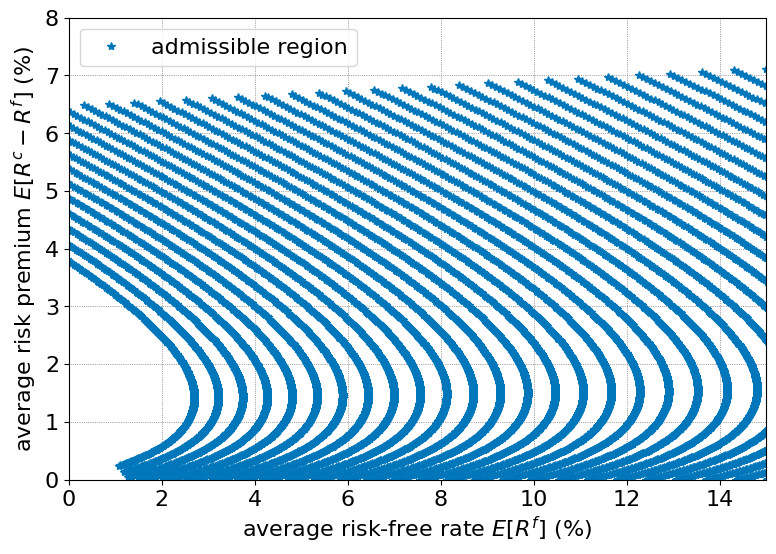

In [23]:
param = {'figsize' : [9,6], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [0,15], 'ylim': [0,8],
         'xlabel': r'average risk-free rate $E[R^f]\ (\%)$', 'ylabel': r'average risk premium $E[R^c - R^f]\ (\%)$',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

fig,ax = ec.GenerateTSPlot(param)

ax.plot((ERf_mat_lower_psi.flatten()-1)*100, ERe_mat_lower_psi.flatten()*100,linewidth=0,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='admissible region');

x = ax.legend(loc="upper left")

fig.set_facecolor('#FFFFFF')

## Analysis

In [24]:
# data = []
# for i,bet in enumerate(beta_vec):
#     for j,gam in enumerate(gamma_vec):
#         data.append(ERf_mat[i,j] - ERf_mat_lower_psi[i,j]) # Average risk-free rate tends to be smaller for lower psi

# plt.hist(data, bins=30, edgecolor='black')
# plt.show()

In [25]:
counter = 0
for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        if ERf_mat[i,j] < ERf_mat_lower_psi[i,j]:
            print(f"Lower psi yields higher average risk-free rate when beta: {beta_vec[i]}, gamma: {gamma_vec[j]}")
            counter += 1

In [26]:
counter / (200 * 400)

0.0

In [27]:
counter = 0
for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        if ERe_mat[i,j] > ERe_mat_lower_psi[i,j]:
            print(f"Lower psi yields lower average risk premium when beta: {beta_vec[i]}, gamma: {gamma_vec[j]}")
            counter += 1

Lower psi yields lower average risk premium when beta: 0.021080402010050254, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.031120603015075382, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.03614070351758794, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.04618090452261307, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.05120100502512563, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.06124120603015076, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.07128140703517588, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.08132160804020101, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.11646231155778895, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.15662311557788947, gamma: 0.0
Lower psi yields lower average risk premium when beta: 0.16666331658291458, gamma: 0.0
Lower psi yields lower average risk premi

In [28]:
counter / (200 * 400)

0.0007375

# Higher $p$

In [29]:
# model specification
model = {"PHI": 0.43, "MU": 0.018, "DELTA": 0.036, "d1": 0.024, "d2": 0.024, "p": 0.05, "psi": 0.85}

model["P"] = np.array([[model["PHI"], 1 - model["PHI"] - model["d1"], model["d1"]], 
                       [1 - model["PHI"] - model["d2"], model["PHI"], model["d2"]],
                       [0.5 - 0.5 * model["p"], 0.5 - 0.5 * model["p"], model["p"]]])

model["GAMMAC"] = np.array([[1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])], 
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])],
                            [1 + model["MU"] + model["DELTA"], 1 + model["MU"] - model["DELTA"], model["psi"] * (1 + model["MU"])]])

model["GAMMAG"] = model["GAMMAC"].copy()

beta_vec = np.linspace(0.001,1,200)
gamma_vec = np.linspace(0,10,400)

# beta_vec = np.linspace(0.000001, 1, 11)
# gamma_vec = np.linspace(0, 10, 11)

ERe_mat_higher_p = np.zeros([len(beta_vec),len(gamma_vec)])
ERf_mat_higher_p = np.zeros([len(beta_vec),len(gamma_vec)])

for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        model["BETA"] = bet
        model["GAMMA"] = gam
        model["SDF"] = model["BETA"] * np.power(model["GAMMAC"],-model["GAMMA"])
        sol = solve_Mehra_Prescott(model)
        ERe_mat_higher_p[i,j] = sol["ERe"]
        ERf_mat_higher_p[i,j] = sol["ERf"]

In [30]:
sol["PII"]

array([[0.48767967],
       [0.48767967],
       [0.02464066]])

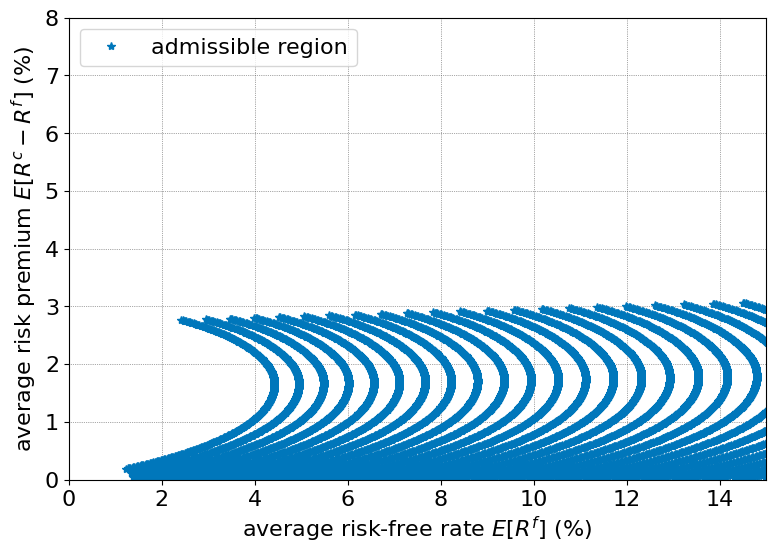

In [31]:
param = {'figsize' : [9,6], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [0,15], 'ylim': [0,8],
         'xlabel': r'average risk-free rate $E[R^f]\ (\%)$', 'ylabel': r'average risk premium $E[R^c - R^f]\ (\%)$',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

fig,ax = ec.GenerateTSPlot(param)

ax.plot((ERf_mat_higher_p.flatten()-1)*100, ERe_mat_higher_p.flatten()*100,linewidth=0,marker='*',color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='admissible region');

x = ax.legend(loc="upper left")

fig.set_facecolor('#FFFFFF')

## Analysis

In [32]:
counter = 0
for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        if ERe_mat[i,j] < ERe_mat_higher_p[i,j]:
            # print(f"Higher p yields higher average risk premium when beta: {beta_vec[i]}, gamma: {gamma_vec[j]}")
            counter += 1

In [33]:
counter / (200 * 400)

0.3516

In [34]:
counter = 0
for i,bet in enumerate(beta_vec):
    for j,gam in enumerate(gamma_vec):
        if ERe_mat[i,j] > ERe_mat_higher_p[i,j]:
            # print(f"Higher p yields lower average risk premium when beta: {beta_vec[i]}, gamma: {gamma_vec[j]}")
            counter += 1

In [35]:
counter / (200 * 400)

0.646275